Import libraries

In [4]:
import glob
import os
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import linregress
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

Specify directories to access and save data

In [5]:
save_dir = '/home/ajp255/nethome/Data/ChlAPlots/'
data_dir = '/home/ajp255/nethome/Data/PartIII_23/GMIS_chlorophyl' 

Initialise coordinates of the CVAO

In [6]:
latitude = 16.864
longitude = -24.8675

Time averaged global distribution of ChlA

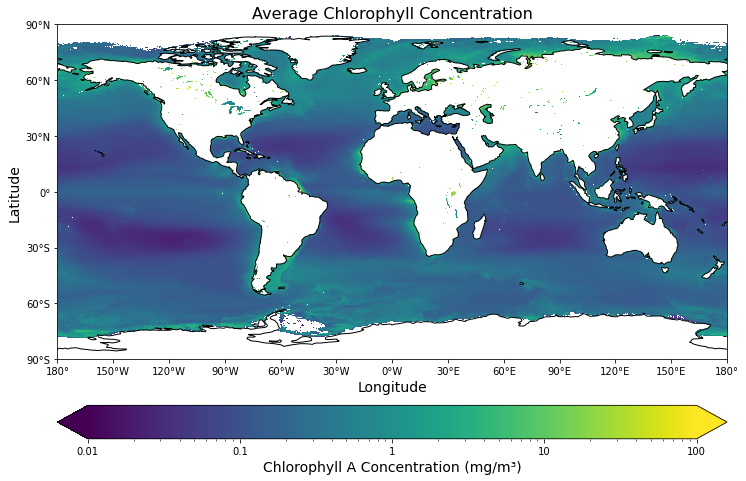

In [2]:
def plot_combined_chlorophyll(file_pattern, title, colorbar_label, filename, vmin=None, vmax=None):
    # Find all files matching the pattern
    files = glob.glob(file_pattern)

    # Combine data from each file
    combined_ds = xr.concat([xr.open_dataset(file) for file in files], dim='time')

    # Apply logarithmic transformation to chlorophyll data
    combined_ds['Chl_a'] = 10 ** combined_ds['Chl_a']
    
    # Calculate the mean chlorophyll concentration over time, ignoring NaN values
    chlorophyll_mean = combined_ds['Chl_a'].mean(dim='time', skipna=True)

    # Set the normalization bounds
    norm = LogNorm(vmin=vmin or chlorophyll_mean.min(), vmax=vmax or chlorophyll_mean.max())

    # Create a scatter plot
    fig = plt.figure(figsize=(12, 17))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.add_feature(cartopy.feature.COASTLINE)

    # Handle multi-dimensional data for scatter plot
    longitude, latitude = np.meshgrid(combined_ds['lon'], combined_ds['lat'])
    sc = ax.pcolormesh(longitude, latitude, chlorophyll_mean, cmap='viridis', norm=norm, shading='auto', transform=ccrs.PlateCarree())

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05, extend='both')
    cbar.set_label(colorbar_label, fontsize=14)

    # Set log-scale ticks and labels
    cbar_ticks = [0.01, 0.1, 1, 10, 100]  # Define the ticks for the colorbar
    cbar.set_ticks(cbar_ticks)  # Set the ticks on the colorbar
    cbar.ax.set_xticklabels(cbar_ticks)  # Set the tick labels

    # Set title and labels
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)

    # Add gridlines and labels
    ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Show the plot
    plt.show()

file_pattern = os.path.join(data_dir, 'GMIS_A_CHLA_*.nc')
plot_combined_chlorophyll(file_pattern, 'Average Chlorophyll Concentration', 'Chlorophyll A Concentration (mg/m³)', 'average_chlorophyll_concentration.png', vmin=0.01, vmax=100)


Global ChlA frequency distribution

In [ ]:
# Find all files matching the pattern
files = glob.glob(f'{data_dir}/*.nc')

# Load the data, concatenate along 'time'
combined_ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')

# Apply logarithmic transformation to chlorophyll data
combined_ds['Chl_a'] = 10 ** combined_ds['Chl_a']

# Extract the Chl_a data as a one-dimensional array, ignoring NaN values
chl_a_data = combined_ds['Chl_a'].values.flatten()
chl_a_data = chl_a_data[~np.isnan(chl_a_data)]  # Remove NaN values

# Define histogram bins and range for Chl_a concentrations
bins = np.logspace(np.log10(chl_a_data.min()), np.log10(chl_a_data.max()), num=50)

# Plot histogram for the Chl_a concentrations
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

# Use log scale on the x-axis
plt.xscale('log')

n_chl_a, bins_chl_a, patches_chl_a = plt.hist(chl_a_data, bins=bins, density=True, histtype='step', facecolor='#2b83ba',
                                              edgecolor='blue', linewidth=2, label="Chl_a Concentration")

# Customize plot
plt.xlabel('Chl_a Concentration (mg/m³)')
plt.ylabel('Frequency')
plt.title('Global Distribution of Chl_a Concentration')
plt.grid(True)
plt.legend(loc='upper right')

# Save the plot to a file
#save_path = os.path.join(save_dir, 'global_chl_a_concentration_histogram.png')
#plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Print mean information
mean_chl_a = np.mean(chl_a_data)  # Calculate mean from non-NaN values
print("Chl_a Concentration Data")
print(f"Mean Chl_a Concentration: {mean_chl_a:.2f}")

plt.show()  # Show the plot

# Close the current figure and the dataset
plt.close()
combined_ds.close()

Focus down on T2 region with CVAO

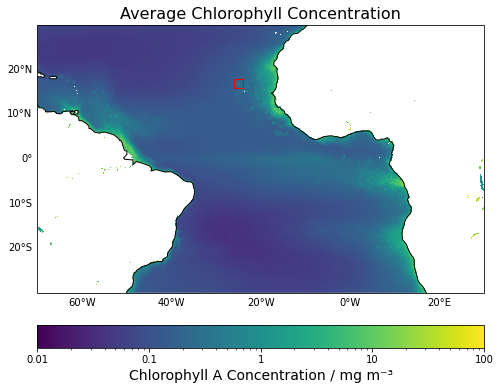

In [7]:
def plot_combined_chlorophyll(file_pattern, title, colorbar_label, filename, vmin=None, vmax=None):
    # Find all files matching the pattern
    files = glob.glob(file_pattern)

    # Combine data from each file
    combined_ds = xr.concat([xr.open_dataset(file) for file in files], dim='time')

    # Apply logarithmic transformation to chlorophyll data
    combined_ds['Chl_a'] = 10 ** combined_ds['Chl_a']
    
    # Calculate the mean chlorophyll concentration over time, ignoring NaN values
    chlorophyll_mean = combined_ds['Chl_a'].mean(dim='time', skipna=True)

    # Set the normalization bounds
    norm = LogNorm(vmin=vmin or chlorophyll_mean.min(), vmax=vmax or chlorophyll_mean.max())

    # Create a scatter plot
    fig = plt.figure(figsize=(8, 12))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.add_feature(cartopy.feature.COASTLINE)

    # Handle multi-dimensional data for scatter plot
    longitude, latitude = np.meshgrid(combined_ds['lon'], combined_ds['lat'])
    sc = ax.pcolormesh(longitude, latitude, chlorophyll_mean, cmap='viridis', norm=norm, shading='auto', transform=ccrs.PlateCarree())

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05, extend='neither')
    cbar.set_label(colorbar_label, fontsize=14)

    # Set log-scale ticks and labels
    cbar_ticks = [0.01, 0.1, 1, 10, 100]  # Define the ticks for the colorbar
    cbar.set_ticks(cbar_ticks)  # Set the ticks on the colorbar
    cbar.ax.set_xticklabels(cbar_ticks)  # Set the tick labels

    # Set title and labels
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14) 

    # Set extent before adding gridlines
    ax.set_extent([290, 390, -30, 30], crs=ccrs.PlateCarree())

    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    gl.xlines = False
    gl.ylines = False
    
    # Define the regions for black rectangles
    regions = {
        'Region1': {'lat_min': 15.864, 'lat_max': 17.864, 'lon_min': -25.8675, 'lon_max': -23.8675},
    }

    # Add red rectangle for CVAO location
    for region in regions.values():
        rectangle = Rectangle((region['lon_min'], region['lat_min']), 
                              region['lon_max'] - region['lon_min'], 
                              region['lat_max'] - region['lat_min'],
                              transform=ccrs.PlateCarree(), 
                              edgecolor='red', facecolor='none')
        ax.add_patch(rectangle)
    
    # Show the plot
    plt.savefig('/home/ajp255/nethome/Data/ChlAPlots/T2_ChlA_map.png', dpi=600, bbox_inches='tight')
    plt.show()

file_pattern = os.path.join(data_dir, 'GMIS_A_CHLA_*.nc')
plot_combined_chlorophyll(file_pattern, 'Average Chlorophyll Concentration', 'Chlorophyll A Concentration / mg m⁻³', 'restricted_average_chlorophyll_concentration.png', vmin=0.01, vmax=100)


Time series of ChlA data at CVAO

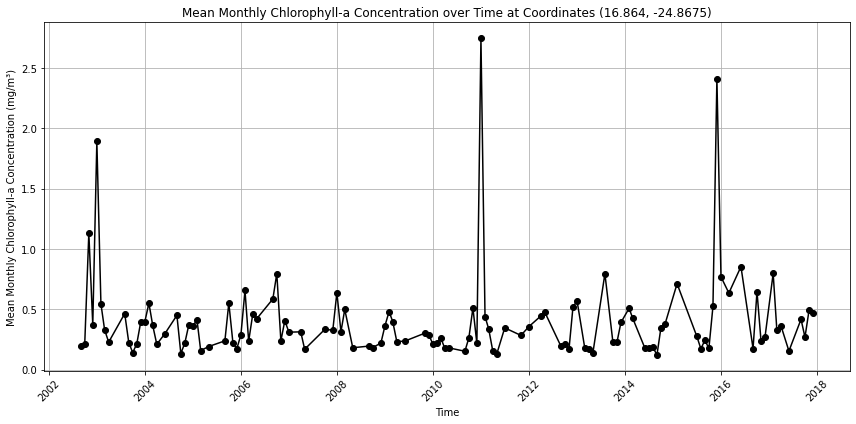

In [6]:
# Initialize a list to store DataFrames
dataframes = []

# Loop through each file in the directory
for filepath in glob.glob(f'{data_dir}/GMIS_A_CHLA_*.nc'):
    # Extract month and year from the filename
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    month, year_with_ext = parts[-2], parts[-1]  # Assuming MM and YYYY are the last two parts before the extension
    year = year_with_ext.split('.')[0]  # Remove file extension

    # Load the dataset
    ds = xr.open_dataset(filepath)

    # Select data at the specific latitude and longitude, apply logarithmic transformation
    chla_value = 10 ** ds.sel(lat=latitude, lon=longitude, method='nearest')['Chl_a'].mean().values.item()

    # Close the dataset
    ds.close()

    # Create a DataFrame for the current iteration
    temp_df = pd.DataFrame({'Year': [int(year)], 'Month': [int(month)], 'Mean_Chla': [chla_value]})

    # Append the DataFrame to the list
    dataframes.append(temp_df)

# Concatenate all DataFrames in the list
monthly_averages = pd.concat(dataframes, ignore_index=True)

# Convert 'Year' and 'Month' to a datetime object
monthly_averages['Date'] = pd.to_datetime(monthly_averages[['Year', 'Month']].assign(DAY=1))

# Sort the DataFrame by 'Date' and drop NaN values
monthly_averages = monthly_averages.dropna()
monthly_averages = monthly_averages.sort_values(by='Date')

# Plot mean concentration vs. time
plt.figure(figsize=(12, 6))
plt.plot(monthly_averages['Date'], monthly_averages['Mean_Chla'], marker='o', linestyle='-', color='k')
plt.xlabel('Time')
plt.ylabel('Mean Monthly Chlorophyll-a Concentration (mg/m³)')
plt.title('Mean Monthly Chlorophyll-a Concentration over Time at Coordinates (16.864, -24.8675)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Store the monthly averages at CVAO

In [7]:
# Initialize a list to store DataFrames
dataframes = []

# Loop through each file in the directory
for filepath in glob.glob(f'{data_dir}/GMIS_A_CHLA_*.nc'):
    # Extract month and year from the filename
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    month, year_with_ext = parts[-2], parts[-1]  # Assuming "MM" and "YYYY.nc" are the last two parts before the extension
    year = year_with_ext.split('.')[0]  # Remove file extension

    # Load the dataset
    ds = xr.open_dataset(filepath)

    # Select data at the specific latitude and longitude, apply logarithmic transformation
    chla_value = 10 ** ds.sel(lat=latitude, lon=longitude, method='nearest')['Chl_a'].mean().values.item()

    # Close the dataset
    ds.close()

    # Create a DataFrame for the current iteration
    temp_df = pd.DataFrame({'year': [int(year)], 'month': [int(month)], 'monthly_mean_chl_a': [chla_value]})

    # Append the DataFrame to the list
    dataframes.append(temp_df)

# Concatenate all DataFrames in the list to form a single DataFrame
monthly_chl_a_averages = pd.concat(dataframes, ignore_index=True)

# Sort the DataFrame by 'Year' and 'Month'
monthly_chl_a_averages = monthly_chl_a_averages.dropna()
monthly_chl_a_averages = monthly_chl_a_averages.sort_values(by=['year', 'month'])

Expanding to 10x10 grid box around CVAO

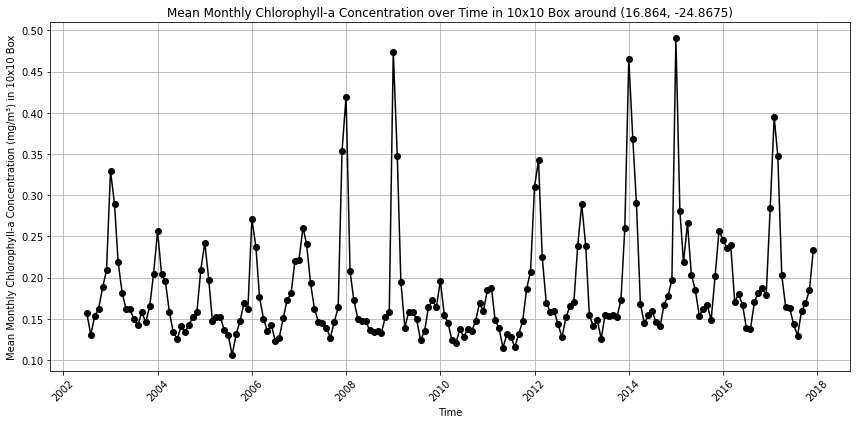

In [30]:
box_size = 1  # Half-size of the box, 5 degrees on each side to make a 10x10 box

# Initialize a list to store DataFrames
dataframes = []

# Loop through each file in the directory
for filepath in glob.glob(f'{data_dir}/GMIS_A_CHLA_*.nc'):
    # Extract month and year from the filename
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    month, year_with_ext = parts[-2], parts[-1]  # Assuming MM and YYYY are the last two parts before the extension
    year = year_with_ext.split('.')[0]  # Remove file extension

    # Load the dataset
    ds = xr.open_dataset(filepath)

    # Define the bounds for the 10x10 box
    lat_min = latitude - box_size
    lat_max = latitude + box_size
    lon_min = longitude - box_size
    lon_max = longitude + box_size

    # Filter the dataset manually for the box
    chla_box = ds['Chl_a'].where((ds.lat >= lat_min) & (ds.lat <= lat_max) & 
                                 (ds.lon >= lon_min) & (ds.lon <= lon_max), drop=True)
    
    # Apply logarithmic transformation and calculate the mean for the filtered data
    chla_value_box = 10 ** chla_box.mean().values.item()

    # Close the dataset
    ds.close()

    # Create a DataFrame for the current iteration
    temp_df = pd.DataFrame({'Year': [int(year)], 'Month': [int(month)], 'Mean_Chla': [chla_value_box]})

    # Append the DataFrame to the list
    dataframes.append(temp_df)

# Concatenate all DataFrames in the list
monthly_averages = pd.concat(dataframes, ignore_index=True)

# Convert 'Year' and 'Month' to a datetime object
monthly_averages['Date'] = pd.to_datetime(monthly_averages[['Year', 'Month']].assign(DAY=1))

# Sort the DataFrame by 'Date' and drop NaN values
monthly_averages = monthly_averages.dropna()
monthly_averages = monthly_averages.sort_values(by='Date')

# Plot mean concentration vs. time for the 10x10 box around the specified coordinates
plt.figure(figsize=(12, 6))
plt.plot(monthly_averages['Date'], monthly_averages['Mean_Chla'], marker='o', linestyle='-', color='k')
plt.xlabel('Time')
plt.ylabel('Mean Monthly Chlorophyll-a Concentration (mg/m³) in 10x10 Box')
plt.title('Mean Monthly Chlorophyll-a Concentration over Time in 10x10 Box around (16.864, -24.8675)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Store the monthly averages in the grid box

In [31]:
box_size = 1  # Half-size of the box, 5 degrees on each side to make a 10x10 box

# Initialize a list to store DataFrames
dataframes = []

# Loop through each file in the directory
for filepath in glob.glob(f'{data_dir}/GMIS_A_CHLA_*.nc'):
    # Extract month and year from the filename
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    month, year_with_ext = parts[-2], parts[-1]  # Assuming "MM" and "YYYY.nc" are the last two parts before the extension
    year = year_with_ext.split('.')[0]  # Remove file extension

    # Load the dataset
    ds = xr.open_dataset(filepath)

    # Define the bounds for the 10x10 box
    lat_min = latitude - box_size
    lat_max = latitude + box_size
    lon_min = longitude - box_size
    lon_max = longitude + box_size

    # Filter the dataset for the box and apply logarithmic transformation
    chla_box = ds['Chl_a'].where((ds.lat >= lat_min) & (ds.lat <= lat_max) & 
                                 (ds.lon >= lon_min) & (ds.lon <= lon_max), drop=True)
    chla_value_box = 10 ** chla_box.mean().values.item()

    # Close the dataset
    ds.close()

    # Create a DataFrame for the current iteration
    temp_df = pd.DataFrame({'year': [int(year)], 'month': [int(month)], 'monthly_mean_chl_a': [chla_value_box]})

    # Append the DataFrame to the list
    dataframes.append(temp_df)

# Concatenate all DataFrames in the list to form a single DataFrame
box_averages = pd.concat(dataframes, ignore_index=True)

# Sort the DataFrame by 'Year' and 'Month'
box_averages = box_averages.dropna()
box_averages = box_averages.sort_values(by=['year', 'month'])

# Merge the two DataFrames on 'year' and 'month' columns
box_combined_df = pd.merge(box_averages, monthly_means, on=['year', 'month'], how='inner')

Extract model and observation ozone data to compare with ChlA

In [32]:
# Create a function to process the model output into a dataframe
def process_model_output_file(file_name, directory_path):
    if "zsurf_stash34001" not in file_name:
        # Skip files that do not contain "stash34001" in their names
        return None

    file_path = os.path.join(directory_path, file_name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'region', 'm01s34i001']

        for variable in variable_list:
            data[variable] = nc_file.variables[variable][:]
    
    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Specify the directory path
directory_path = "/scratch/ajp255/homes/mrr32/home/data/PartIII_23/Model_Output"

# List all NetCDF files in the directory containing "stash34001" in their names
file_list = [f for f in os.listdir(directory_path) if f.endswith(".nc") and "stash34001" in f]

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through the filtered files
for file_name in file_list:
    df = process_model_output_file(file_name, directory_path)
    if df is not None:
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
model_data = pd.concat(dfs, ignore_index=True)

# Convert O3 model data to ppbv
cfactor = 1.e9 / 1.657
model_data = model_data.rename(columns={'m01s34i001': 'ozone'})
model_data['ozone'] = model_data['ozone']*cfactor

# Sort the DataFrame by the 'time' column in ascending order
model_data = model_data.sort_values(by='time', ascending=True)
mod_cvao = model_data[model_data['region'] == 'CVAO_O3']

# Specify the directory containing the files
directory_path = '/scratch/ajp255/homes/mrr32/home/data/PartIII_23/CVAO/O3'

# List all files in the directory
file_names = os.listdir(directory_path)

# Create a Pandas DataFrame from the file names
df = pd.DataFrame({'file_name': file_names})

# Extract information from file names
df['base_date'] = df['file_name'].str.extract(r'(\d{8})')

# Convert 'base_date' to datetime format
df['base_date'] = pd.to_datetime(df['base_date'], format='%Y%m%d')
df = df.sort_values(by='base_date', ascending=True)

def process_netcdf_file(file_info, directory_path):
    name, base_date = file_info
    file_path = os.path.join(directory_path, name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'o3_concentration_in_air', 'qc_flag']

        for variable in variable_list:
            if variable in nc_file.variables:
                if variable == 'o3_concentration_in_air':
                    data['ozone'] = nc_file.variables[variable][:]
                else:
                    data[variable] = nc_file.variables[variable][:]

        # Repeat latitude and longitude values for every row
        if 'latitude' in data:
            data['latitude'] = np.repeat(data['latitude'], len(data['time']))

        # Set constant longitude for every row (from observatory coordinates)
        constant_longitude = -24.8672  
        data['longitude'] = np.full(len(data['time']), constant_longitude)
        
        # Create a new column 'altitude' and assign a value of 45 for every row
        #data['altitude'] = 300
        
        # Convert time to days
        sec_per_day = 24 * 60 * 60
        data['time'] = data['time'] / sec_per_day

    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Create an empty list to store individual DataFrames
dataframes = []

for name, base_date in zip(df['file_name'], df['base_date']):
    result = process_netcdf_file((name, base_date), directory_path)
    if result is not None:
        dataframes.append(result)

# Concatenate all individual DataFrames into a single DataFrame
obs_cvao = pd.concat(dataframes, ignore_index=True)

model_base_date = datetime(1900, 1, 1)
model_start_date = datetime(1986, 1, 1)
obs_base_date = datetime(1970, 1, 1)
start_days_difference = (model_start_date - model_base_date).days
last_model_date = 44710.957639
obs_cvao['time'] = obs_cvao['time'] + (obs_base_date - model_base_date).days
obs_cvao = obs_cvao[(obs_cvao['time'] >= start_days_difference) & (obs_cvao['time'] <= last_model_date)]
obs_cvao = obs_cvao.sort_values(by='time', ascending=True)

# Reset indices to ensure alignment
mod_cvao_reset = mod_cvao.reset_index(drop=True)
obs_cvao_reset = obs_cvao.reset_index(drop=True)

# Create merge_df
merge_df = pd.DataFrame()

# Copy time, latitude, and longitude columns from mod_cvao to merge_df
merge_df['time'] = mod_cvao_reset['time'].copy()
merge_df['latitude'] = mod_cvao_reset['latitude'].copy()
merge_df['longitude'] = mod_cvao_reset['longitude'].copy()
merge_df['mod_ozone'] = mod_cvao_reset['ozone'].copy()
merge_df['obs_ozone'] = obs_cvao_reset['ozone'].copy()

# Calculate ozone_mergeerence as mod_cvao['ozone'] - obs_cvao['ozone']
merge_df['ozone_difference'] = mod_cvao_reset['ozone'] - obs_cvao_reset['ozone']

# Drop rows where either "mod_ozone" or "obs_ozone" is NaN
merge_df = merge_df.dropna(subset=['mod_ozone', 'obs_ozone'])

# Convert 'time' to a datetime format to extract year and month
merge_df['datetime'] = pd.to_datetime(merge_df['time'], origin='1900-01-01', unit='D')

# Extract year and month from 'datetime' for grouping
merge_df['year'] = merge_df['datetime'].dt.year
merge_df['month'] = merge_df['datetime'].dt.month

# Group by year and month and calculate monthly means
monthly_means = merge_df.groupby(['year', 'month']).agg({
    'mod_ozone': 'mean',
    'obs_ozone': 'mean',
    'ozone_difference': 'mean'
}).reset_index()

# Rename the columns for clarity
monthly_means.rename(columns={
    'mod_ozone': 'Monthly_Mean_Mod_Ozone',
    'obs_ozone': 'Monthly_Mean_Obs_Ozone',
    'ozone_difference': 'Monthly_Mean_Ozone_Difference'
}, inplace=True)

# Merge the two DataFrames on 'year' and 'month' columns
combined_df = pd.merge(monthly_chl_a_averages, monthly_means, on=['year', 'month'], how='inner')

Time series of ChlA vs model bias

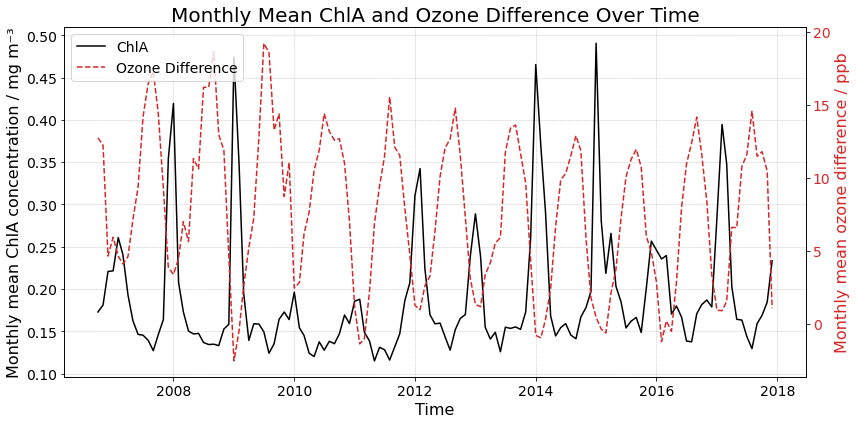

In [33]:
# Convert 'year' and 'month' in monthly_means to a datetime object
monthly_means['Date'] = pd.to_datetime(monthly_means[['year', 'month']].assign(DAY=1))

# Merge the two DataFrames on the 'Date' column
merged_data = pd.merge(monthly_averages, monthly_means, on='Date', how='inner')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting Mean Monthly Chlorophyll-a Concentration in 10x10 Box on the first y-axis
color_chla = 'black'
ax1.set_xlabel('Time', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.set_ylabel('Monthly mean ChlA concentration / mg m⁻³', color=color_chla, fontsize=16)
ax1.plot(merged_data['Date'], merged_data['Mean_Chla'], linestyle='-', color=color_chla, label='ChlA')
ax1.tick_params(axis='y', labelcolor=color_chla, labelsize=14)

# Create a second y-axis for the Monthly Mean Ozone Difference
ax2 = ax1.twinx()
color_ozone = 'tab:red'
ax2.set_ylabel('Monthly mean ozone difference / ppb', color=color_ozone, fontsize=16)
ax2.plot(merged_data['Date'], merged_data['Monthly_Mean_Ozone_Difference'], linestyle='--', color=color_ozone, label='Ozone Difference')
ax2.tick_params(axis='y', labelcolor=color_ozone, labelsize=14)

# Set title and adjust layout
plt.title('Monthly Mean ChlA and Ozone Difference Over Time', fontsize=20)
fig.tight_layout()  # Adjust layout to not overlap

# Adjust grid and legend for clarity
ax1.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Adding a legend that combines both plots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=14)

plt.savefig('/home/ajp255/nethome/Data/ChlAPlots/CVAO_ChlA_timeseries.png', dpi=600)

plt.show()

Time-matched scatter plot of ChlA vs bias at CVAO and in grid box

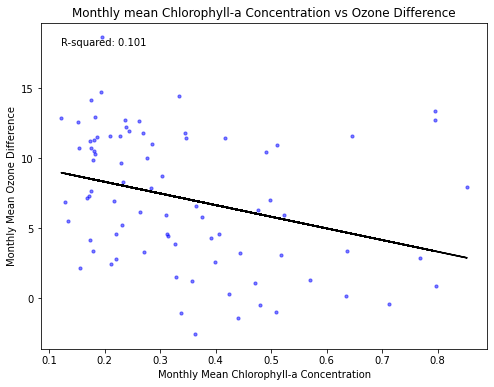

In [34]:
# Filter the combined DataFrame to exclude rows where 'Monthly_Mean_Chl_a' is over 1.0
filtered_df = combined_df[combined_df['monthly_mean_chl_a'] <= 1.0]

# Extract chl_a and ozone difference data from the filtered DataFrame
chl_a_filtered = filtered_df['monthly_mean_chl_a']
ozone_diff_filtered = filtered_df['Monthly_Mean_Ozone_Difference']

# Perform linear regression on the filtered data
slope, intercept, r_value, _, _ = linregress(chl_a_filtered, ozone_diff_filtered)

# Plot scatter plot for the filtered data
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

plt.scatter(chl_a_filtered, ozone_diff_filtered, color='blue', s=10, alpha=0.5, label='Filtered Data Points')

# Add a linear regression line for the filtered data
plt.plot(chl_a_filtered, slope * chl_a_filtered + intercept, linestyle='solid', color='black', label='Regression Line')

# Customize plot
plt.xlabel('Monthly Mean Chlorophyll-a Concentration')
plt.ylabel('Monthly Mean Ozone Difference')
plt.title('Monthly mean Chlorophyll-a Concentration vs Ozone Difference')

# Show R-squared value on the plot for the filtered data
plt.text(min(chl_a_filtered), max(ozone_diff_filtered), f'R-squared: {r_value**2:.3f}', verticalalignment='top')

# Show the plot
plt.show()

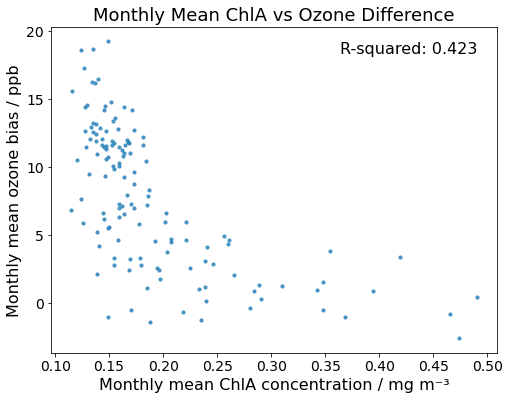

In [58]:
# Filter the combined DataFrame to exclude rows where 'Monthly_Mean_Chl_a' is over 1.0
#filtered_df = box_combined_df[box_combined_df['monthly_mean_chl_a'] <= 1.0]

# Extract chl_a and ozone difference data from the filtered DataFrame
chl_a_filtered = filtered_df['monthly_mean_chl_a']
ozone_diff_filtered = filtered_df['Monthly_Mean_Ozone_Difference']

# Perform linear regression on the filtered data
slope, intercept, r_value, _, _ = linregress(chl_a_filtered, ozone_diff_filtered)

# Plot scatter plot for the filtered data
plt.figure(figsize=(8, 6))

plt.scatter(chl_a_filtered, ozone_diff_filtered, color='#2b83ba', s=10, alpha=0.8, label='Filtered Data Points')

# Add a linear regression line for the filtered data
#plt.plot(chl_a_filtered, slope * chl_a_filtered + intercept, linestyle='solid', color='black', label='Regression Line')

# Customise plot
plt.xlabel('Monthly mean ChlA concentration / mg m⁻³', fontsize=16)
plt.ylabel('Monthly mean ozone bias / ppb', fontsize=16)
plt.title('Monthly Mean ChlA vs Ozone Difference', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) 

# Show R-squared value on the plot for the filtered data
plt.text(max(chl_a_filtered), max(ozone_diff_filtered), f'R-squared: {r_value**2:.3f}', verticalalignment='top', horizontalalignment='right', fontsize=16)

plt.savefig('/home/ajp255/nethome/Data/ChlAPlots/CVAO_ChlA_correlation.png', dpi=600)

# Show the plot
plt.show()

Splitting the correlation into clusters of linear regimes

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f638d4b4b80>
Traceback (most recent call last):
  File "/usr/local/shared/anaconda/python3/2021.11/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/shared/anaconda/python3/2021.11/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/shared/anaconda/python3/2021.11/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/shared/anaconda/python3/2021.11/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f63db7c21f0>
Traceback (most recent call last):
  File "/usr/local/shared/anaconda/python3/2021.11/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/shared/anaconda/python3/2021.11/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/shared/anaconda/python3/2021.11/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/shared/anaconda/python3/2021.11/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

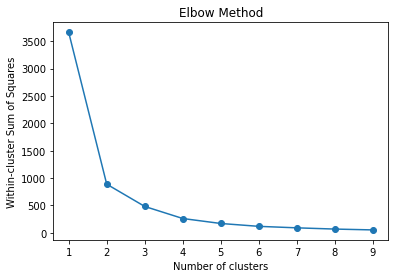

In [51]:
data = filtered_df[['monthly_mean_chl_a', 'Monthly_Mean_Ozone_Difference']]

# Calculate the within-cluster sum of squares for different numbers of clusters
inertias = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(data)
    inertias.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()

Cluster 0:
  Slope (Gradient): -71.6811
  Intercept: 23.1286
  R-squared: 0.2480

Cluster 1:
  Slope (Gradient): -17.7894
  Intercept: 7.2690
  R-squared: 0.3320



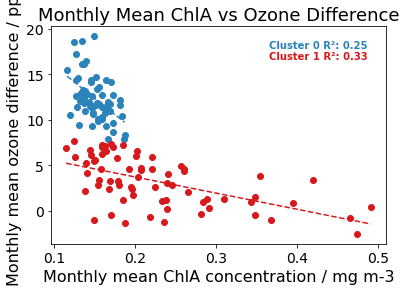

In [57]:
# Perform KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(filtered_df[['monthly_mean_chl_a', 'Monthly_Mean_Ozone_Difference']])
filtered_df['cluster'] = clusters

# Initialize the plot
fig, ax = plt.subplots()

# Different colors for the clusters
colors = ['#2b83ba', '#d7191c']

# Plot and fit a line of best fit for each cluster
for idx, cluster in enumerate(filtered_df['cluster'].unique()):
    cluster_data = filtered_df[filtered_df['cluster'] == cluster]
    ax.scatter(cluster_data['monthly_mean_chl_a'], cluster_data['Monthly_Mean_Ozone_Difference'], label=f'Cluster {cluster}', color=colors[idx])
    
    # Calculate line of best fit for each cluster
    slope, intercept, r_value, _, _ = linregress(cluster_data['monthly_mean_chl_a'], cluster_data['Monthly_Mean_Ozone_Difference'])
    x_vals = np.linspace(cluster_data['monthly_mean_chl_a'].min(), cluster_data['monthly_mean_chl_a'].max(), 100)
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, linestyle='--', color=colors[idx])
    
    # Calculate R-squared value
    y_predicted = intercept + slope * cluster_data['monthly_mean_chl_a']
    r_squared = r2_score(cluster_data['Monthly_Mean_Ozone_Difference'], y_predicted)
    
    # Print the statistics
    print(f"Cluster {cluster}:")
    print(f"  Slope (Gradient): {slope:.4f}")
    print(f"  Intercept: {intercept:.4f}")
    print(f"  R-squared: {r_squared:.4f}\n")
    
    # Annotate the R-squared value on the plot
    plt.annotate(f'Cluster {cluster} R²: {r_squared:.2f}', 
                 xy=(0.65, 0.90 - idx * 0.05), xycoords='axes fraction', 
                 color=colors[idx], fontsize=10, weight='bold')

ax.tick_params(axis='both', which='major', labelsize=14) 
ax.set_xlabel('Monthly mean ChlA concentration / mg m-3', fontsize=16)
ax.set_ylabel('Monthly mean ozone difference / ppb', fontsize=16)
plt.title('Monthly Mean ChlA vs Ozone Difference', fontsize=18)
plt.show()


Applying a logarithmic scale to ChlA

R^2: 0.4918491681314243


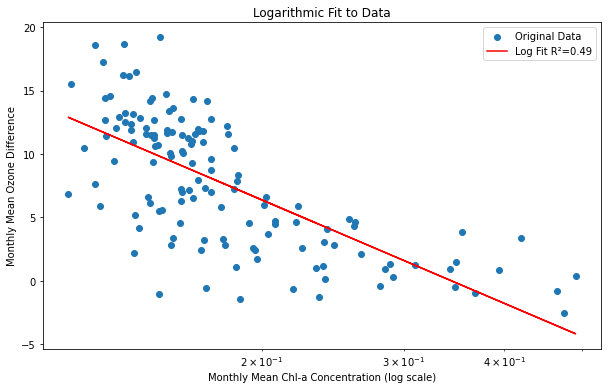

In [53]:
# Define the logarithmic function for fitting
def log_func(x, a, b):
    return a + b * np.log(x)

# Perform the curve fit
popt, pcov = curve_fit(log_func, filtered_df['monthly_mean_chl_a'], filtered_df['Monthly_Mean_Ozone_Difference'])

# Calculate the fitted values
fitted_values = log_func(filtered_df['monthly_mean_chl_a'], *popt)

# Calculate the R^2 value
r2 = r2_score(filtered_df['Monthly_Mean_Ozone_Difference'], fitted_values)
print(f'R^2: {r2}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['monthly_mean_chl_a'], filtered_df['Monthly_Mean_Ozone_Difference'], label='Original Data')
plt.plot(filtered_df['monthly_mean_chl_a'], fitted_values, color='red', label=f'Log Fit R²={r2:.2f}')
plt.xscale('log')
plt.xlabel('Monthly Mean Chl-a Concentration (log scale)')
plt.ylabel('Monthly Mean Ozone Difference')
plt.title('Logarithmic Fit to Data')
plt.legend()
plt.show()


Interannual variation of ChlA around CVAO

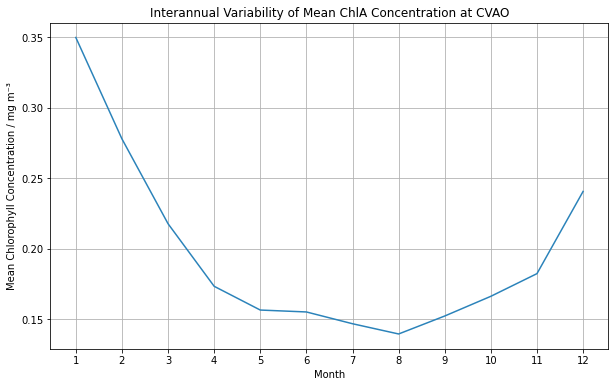

In [63]:
# Define regions with their latitude and longitude bounds
regions = {
    'CVAO': {'lat_min': 15.864, 'lat_max': 17.864, 'lon_min': -25.8675, 'lon_max': -23.8675}
}

# Iterate through each region
for region_name, bounds in regions.items():
    mean_concentrations = []  # Store mean concentrations for each month
    months = list(range(1, 13))  # Months from 1 to 12

    # Iterate through each month
    for month in months:
        month_str = f'{month:02d}'  # Convert month to string format (e.g., '01', '02')
        files = glob.glob(f'{data_dir}/GMIS_A_CHLA_{month_str}_*.nc')  # Find files for the specific month

        if files:
            combined_ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
            combined_ds['Chl_a'] = 10 ** combined_ds['Chl_a']  # Logarithmic transformation

            # Filter data based on region's latitude and longitude bounds
            filtered_ds = combined_ds.where(
                (combined_ds.lat >= bounds['lat_min']) &
                (combined_ds.lat <= bounds['lat_max']) &
                (combined_ds.lon >= bounds['lon_min']) &
                (combined_ds.lon <= bounds['lon_max']),
                drop=True
            )

            # Calculate mean chlorophyll concentration
            mean_chl_a = filtered_ds['Chl_a'].mean().values.item()
            mean_concentrations.append(mean_chl_a)
        else:
            mean_concentrations.append(0)  # Append 0 if no data for the month

    # Plot mean concentration vs month for the region
    plt.figure(figsize=(10, 6))
    plt.plot(months, mean_concentrations, linestyle='-', color='#2b83ba')
    plt.xlabel('Month')
    plt.ylabel('Mean Chlorophyll Concentration / mg m⁻³')
    plt.title(f'Interannual Variability of Mean ChlA Concentration at {region_name}')
    plt.xticks(months)
    plt.grid(True)

    # Save the plot for each region
    save_path = os.path.join(save_dir, f'interannual_chla_{region_name}.png')
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.savefig('/home/ajp255/nethome/Data/ChlAPlots/interannual_chla_CVAO.png', dpi=600, bbox_inches='tight')

    plt.show()